# Train a Neural Network on a 2D regression task
This notebook goes through training a small neural network for a 2D classification task.
Let's first look at the data we will fit. 


In [46]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

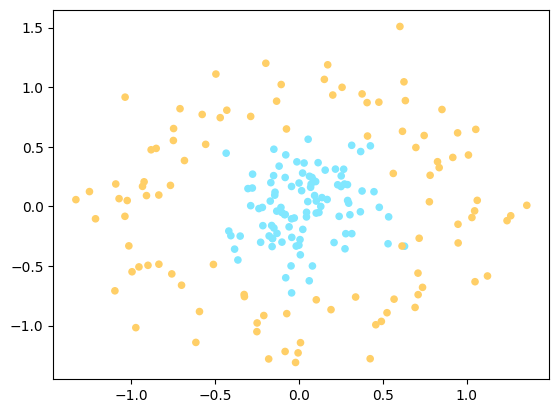

In [47]:
data, targets = make_circles(noise=0.2, random_state=1825, factor=0.2, n_samples=200)

plt.scatter(data[:, 0], data[:, 1], c=targets, s=20, cmap="managua")
plt.show()

In [48]:
data[:5], targets[:5]

(array([[ 0.08764348,  0.21809965],
        [ 0.53489651, -0.08776531],
        [ 0.62602441,  1.04487492],
        [ 0.36653754, -0.04518111],
        [-0.24976615, -1.05062288]]),
 array([1, 1, 0, 1, 0]))

## Neural Network
Now, we'll define a small neural network to learn this data. 
The network is simply a Python function that takes inputs from the dataset and the network parameters. 
When `minijax.eval.Arrays` are given to the function as arguments, `minijax` can run and transform the network.

In [49]:
from minijax.core import relu
from minijax.eval import Array, zeros
from minijax.random import rand_uniform


In [50]:
def network(x, params):
    layer1_params, layer2_params = params
    # @ is matmul
    z = layer1_params["weight"] @ x + layer1_params["bias"]
    z = relu(z)
    return layer2_params["weight"] @ z + layer2_params["bias"]


We'll initialize the parameters randomly. 
The shape of the parameter arrays determines the number of layers of the network. 

In [51]:
input_size = 2
hidden_neurons = 5
out_size = 1

params = [
    {"weight": rand_uniform((hidden_neurons, input_size), rng_key=0), "bias": zeros(hidden_neurons)},
    {"weight": rand_uniform((out_size, hidden_neurons), rng_key=1), "bias": zeros(out_size)},
]

In [52]:
x = Array(data[0])
network(x, params)

Array([0.38432352])

## vmap

So far, the network only works for a single data point. 

In [53]:
x = Array(data[:5])
network(x, params)  # this will throw a ValueError

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (5,2)->(5,newaxis,2) (5,2)->(2,5) 

Let's fix that using `vmap`! The `vmap` function transformation adds a batch axis to `network`.

In [54]:
from minijax.vmap import vmap

In [55]:
network2 = vmap(network, (0, None))  # None means that the params don't have a batch axis
network2(x, params)

Array([[0.38432352]
       [0.54505089]
       [2.09419845]
       [0.39248002]
       [0.        ]])

## grad
Let's plot the decision boundary of the network to compare it with the data.


In [56]:
import numpy as np

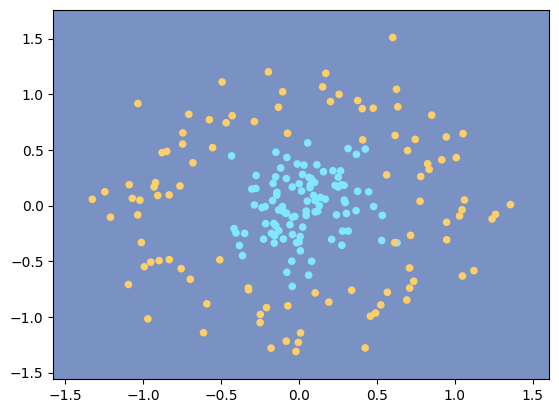

In [57]:
def plot_decision_boundary(params):
    x1 = np.linspace(data[:,0].min() - 0.25, data[:,0].max() + 0.25, 100)
    x2 = np.linspace(data[:,1].min() - 0.25, data[:,1].max() + 0.25, 100)
    x1, x2 = np.meshgrid(x1, x2)
    x = np.stack([x1.ravel(), x2.ravel()], axis=1)
    score = network2(Array(x), params)
    score = score.array.reshape(100, 100)
    plt.contourf(x1, x2, score >= 0, cmap="managua", alpha=0.8)
    plt.scatter(data[:, 0], data[:, 1], c=targets, s=20, cmap="managua")

plot_decision_boundary(params)

Let's see how much we can improve this with one step of gradient descent.
For that we'll define a loss function and compute the gradient of that loss function. 

In [58]:
from minijax.core import exp, log, reduce_sum, reshape
from minijax.grad import grad


In [59]:
def loss(params, x, y_true):
    scores = network2(x, params)
    y_pred = Array(1) / (Array(1) + exp(-scores))  # sigmoid(scores)
    y_true = reshape(y_true, (-1, 1))
    error = y_true * log(y_pred) + (Array(1) - y_true) * log(Array(1) - y_pred)
    return -reduce_sum(error) / Array(data.shape[0])  # cross-entropy loss

grad_fn = grad(loss)
g = grad_fn(params, Array(data[:10]), Array(targets[:10]))[0]
g

[{'weight': Array([[0.00279349 0.00438058]
         [0.00518757 0.00813483]
         [0.00088364 0.0011086 ]
         [0.00581485 0.00729518]
         [0.0019114  0.002398  ]]),
  'bias': Array([0.00202628 0.00376285 0.0009229  0.00607316 0.00199632])},
 {'weight': Array([[0.00578555 0.00036509 0.01200418 0.00932832 0.01052298]]),
  'bias': Array([0.01145896])}]

The gradient has the same structure as params: it's a list of dictionaries, of `Array`s.

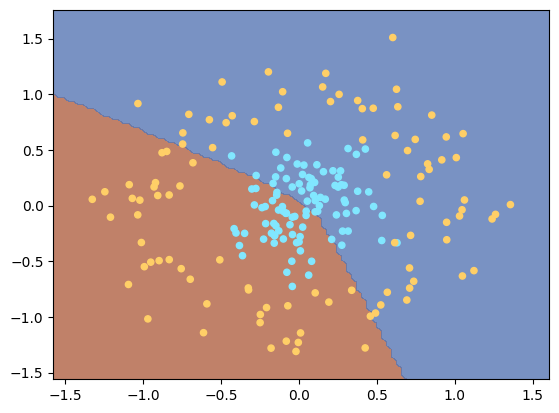

In [60]:
lr = Array(2.0)
new_params = [  # SGD update
    {key: params_[key] - lr * g_[key] for key in params_} for params_, g_ in zip(params, g)
]

plot_decision_boundary(new_params)

That's at least a little better. Let's iterate this.

## jit
Just-in-time compiling (jit'ing) the gradient update will make the update a little faster (no comparison to jax though). 


In [61]:
from minijax.jit import jit
from minijax.nested_containers import map_structure

In [62]:
lr = Array(2.0)
batch_size = 10

@jit
def train_step(params, x, y_true):
    g = grad_fn(params, x, y_true)[0]
    # The map_structure function applies the lambda to each array in the list of dicts.
    # Exactly the same as the list/dict expression two cells above.
    return map_structure(lambda p, g: p - lr * g, params, g)

In [63]:
for epoch in range(300):
    for i in range(data.shape[0] // batch_size):
        x, y_true = data[i*batch_size:(i+1)*batch_size], targets[i*batch_size : (i+1)*batch_size]
        x, y_true = Array(x), Array(y_true)
        new_params = train_step(new_params, x, y_true)

    if epoch % 50 == 49:
        print(epoch+1, ":", loss(new_params, Array(data), Array(targets)))

50 : Array(0.42479712349053844)
100 : Array(0.14369618997026024)
150 : Array(0.1085777506936347)
200 : Array(0.09859769380409665)
250 : Array(0.09444214760702181)
300 : Array(0.0922596683763497)


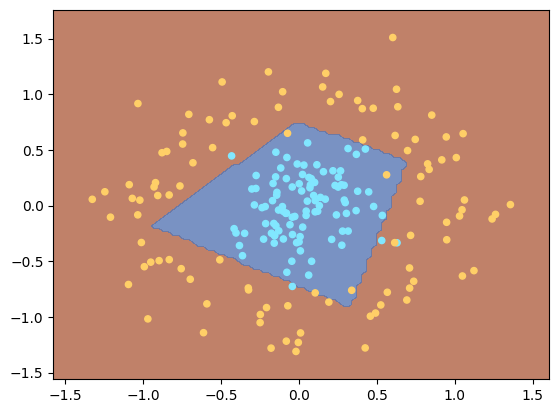

In [64]:
plot_decision_boundary(new_params)

That's decent. Try increasing the number of hidden neurons above to produce a better fit.

We combined three function transformations to get this result: `vmap`, `grad`, and `jit`. 
In fact, evaluating `network` is implemented in a very similar way as these transformations
in `minijax`. Evaluation is implemented in `minijax.eval`. That is a good place to start
looking through the code to make sense of `minijax.core`.

The `train_mnist` notebook contains a more elaborate example of fitting a multi-layer
perceptron to the MNIST dataset.